In [1]:
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.utils import plot_model
from keras.optimizers import Adam,SGD
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K

from glob import glob
from matplotlib import pyplot as plt
from numpy.linalg import inv
import cv2
import random
import numpy as np
import time
import os

In [2]:
def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.maximum(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True), K.epsilon()))

def homography_regression_model():
    input_shape=(128, 128, 2)
    input_img = Input(shape=input_shape)
     
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv1")(input_img)
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv2")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x)
    
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv3")(x)
    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv4")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)
   
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv5")(x)
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv6")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3')(x)
    
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv7")(x)
    x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv8")(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75, noise_shape=None, seed=None)(x)
    x = Dense(1024, name='FC1')(x)
    out = Dense(8, name='loss')(x)
    
    model = Model(inputs=input_img, outputs=[out])
    plot_model(model, to_file='documentation_images/HomegraphyNet_Regression.png', show_shapes=True)
    
    model.compile(optimizer=Adam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=euclidean_distance)
    return model

In [3]:
#visualizing the model
model = homography_regression_model()
model.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      1216      
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64

In [4]:
# result_dir = './results/004/'
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)

In [5]:
def get_test(path):
    rho = 32
    patch_size = 128
    height = 240
    width = 320
    
    #random read image
    loc_list = glob(path)
    index = random.randint(0, len(loc_list)-1)
    img_file_location = loc_list[index]
    color_image = plt.imread(img_file_location)
    color_image = cv2.resize(color_image,(width,height))
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
    
    #points
    y = random.randint(rho, height - rho - patch_size)  # row
    x = random.randint(rho,  width - rho - patch_size)  # col
    top_left_point = (x, y)
    bottom_left_point = (patch_size + x, y)
    bottom_right_point = (patch_size + x, patch_size + y)
    top_right_point = (x, patch_size + y)
    four_points = [top_left_point, bottom_left_point, bottom_right_point, top_right_point]
    four_points_array = np.array(four_points)
    perturbed_four_points = []
    for point in four_points:
        perturbed_four_points.append((point[0] + random.randint(-rho, rho), point[1] + random.randint(-rho, rho)))
        
    #compute H
    H = cv2.getPerspectiveTransform(np.float32(four_points), np.float32(perturbed_four_points))
    H_inverse = inv(H)
    inv_warped_image = cv2.warpPerspective(gray_image, H_inverse, (width, height))
    # grab image patches
    original_patch = gray_image[y:y + patch_size, x:x + patch_size]
    warped_patch = inv_warped_image[y:y + patch_size, x:x + patch_size]
    # make into dataset
    training_image = np.dstack((original_patch, warped_patch))
    val_image = training_image.reshape((1,128,128,2))
    
    return color_image, H_inverse,val_image,four_points_array

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


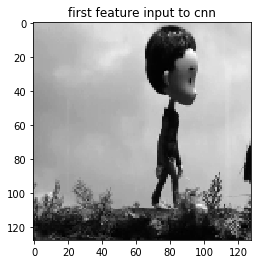

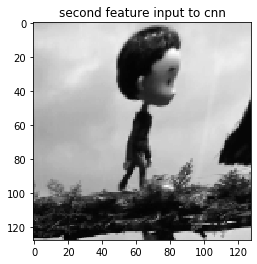

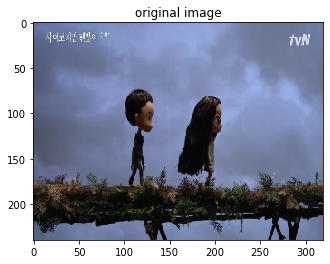

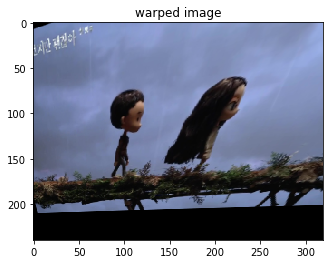

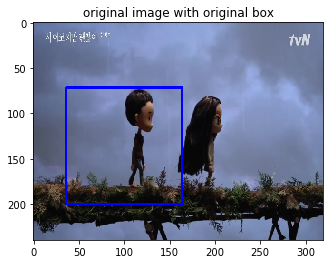

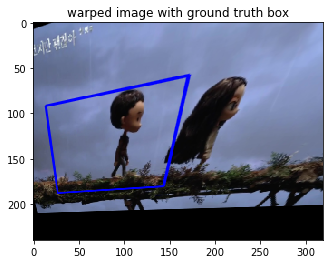

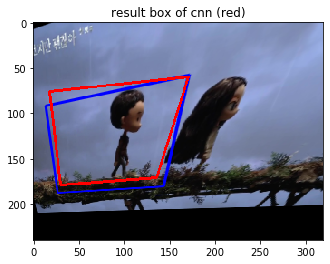

In [6]:
#voc image test 
K.clear_session()
model = homography_regression_model()
model.load_weights('./pretrained_model/pretrained_weights.h5')

color_image, H_matrix,val_image,four_points_array = get_test("./test_images/*.jpg")
plt.imshow(val_image[0, :, :, 0], cmap='gray')
# plt.imsave(os.path.join(result_dir, 'cnn_inp1.jpg'), val_image[0, :, :, 0], cmap='gray')
plt.title('first feature input to cnn')
plt.show()
plt.imshow(val_image[0, :, :, 1], cmap='gray')
# plt.imsave(os.path.join(result_dir, 'cnn_inp2.jpg'), val_image[0, :, :, 1], cmap='gray')
plt.title('second feature input to cnn')
plt.show()

four_points_array_ = four_points_array.reshape((1,4,2))
rectangle_image = cv2.polylines(np.copy(color_image), four_points_array_, 1, (0,0,255),2)
warped_image = cv2.warpPerspective(color_image, H_matrix, (color_image.shape[1], color_image.shape[0]))
plt.imshow(color_image)
plt.title('original image')
plt.show()
# plt.imsave(os.path.join(result_dir, 'original.jpg'), color_image)
plt.imshow(warped_image)
plt.title('warped image')
plt.show()
# plt.imsave(os.path.join(result_dir, 'warped.jpg'), warped_image)

warped_image_box = cv2.warpPerspective(rectangle_image, H_matrix, (color_image.shape[1], color_image.shape[0]))
plt.imshow(rectangle_image)
plt.title('original image with original box')  
plt.show()
plt.imshow(warped_image_box)
plt.title('warped image with ground truth box')  
plt.show()
# plt.imsave(os.path.join(result_dir, 'warped_bl.jpg'), warped_image_box)

val_image = K.constant(val_image)
labels = model.predict(val_image)
K.clear_session()
labels_ = np.int32(labels.reshape((4,2)))
perturbed_four = np.subtract(four_points_array, labels_)
perturbed_four_ = perturbed_four.reshape((1,4,2))
warped_image_box = cv2.polylines(warped_image_box, perturbed_four_, 1, (255,0,0),2)

plt.imshow(warped_image_box) 
plt.title('result box of cnn (red)')
plt.show()

In [7]:
# functions for conventional homography estimation method
def DetectAndDescribe(image):

    descriptor = cv2.xfeatures2d.SIFT_create()
    kps, features = descriptor.detectAndCompute(image, None)

    kps = np.float32([kp.pt for kp in kps])

    return kps, features


def MatchKeyPoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []

    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    if len(matches) > 4:
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])

        H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return matches, H, status


In [8]:
# Applying conventional homography estimation method to chosen pair of images
kpsA, featA = DetectAndDescribe(color_image)
kpsB, featB = DetectAndDescribe(warped_image)

matches, H_mat, status = MatchKeyPoints(kpsA, kpsB, featA, featB, ratio=0.7, reprojThresh=4.0)

In [9]:
# Find box coordinate using homography matrix obtained from above conventional method
fin_cordi = np.zeros((4, 2))
for i in range(4):
    pnt1 = np.array([four_points_array[i][0], four_points_array[i][1], 1])
    pnt1 = pnt1.reshape(3, 1)
#     print(pnt1[:-1, :])
    pnt2 = np.dot(H_mat, pnt1)
    pnt2 = pnt2/pnt2[2]
    pnt2 = pnt2[:-1,:]
    fin_cordi[i][0] = pnt2[0][0]
    fin_cordi[i][1] = pnt2[1][0]
#     print(pnt2)
print(four_points_array)
print(fin_cordi)
fin_cordi = np.int32(fin_cordi)
fin_cordi = fin_cordi.reshape((1, 4, 2))

[[ 36  72]
 [164  72]
 [164 200]
 [ 36 200]]
[[ 13.49169117  91.57733486]
 [170.87556422  58.98289215]
 [143.9691854  180.58076479]
 [ 26.69144385 187.57525605]]


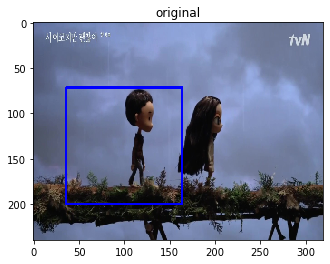

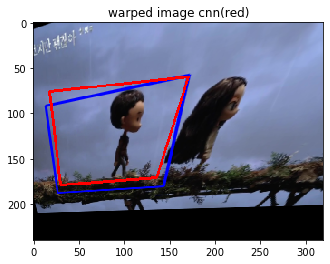

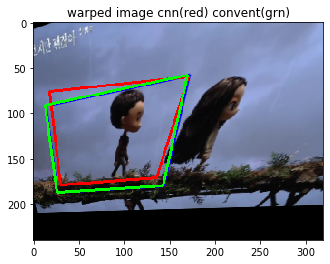

In [10]:
# Visualization to compare between conventional method (green box) and CNN method (red box), ground truth (blue box)
plt.imshow(rectangle_image) 
plt.title('original')
plt.show()
# plt.imsave(os.path.join(result_dir, 'rectangle.jpg'), rectangle_image)

plt.imshow(warped_image_box) 
plt.title('warped image cnn(red)')
plt.show()
# plt.imsave(os.path.join(result_dir, 'warped_bl_rd.jpg'), warped_image_box)

warped_image_green = cv2.polylines(warped_image_box, fin_cordi, 1, (0,255,0),2)
plt.imshow(warped_image_green) 
plt.title('warped image cnn(red) convent(grn)')
plt.show()
# plt.imsave(os.path.join(result_dir, 'warped_bl_rd_gr.jpg'), warped_image_green)